In [16]:
# Libs
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.models import resnet18
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import (
    show_cam_on_image, deprocess_image, preprocess_image
)
import random

In [17]:
class MyImageFolder(datasets.ImageFolder):  
    def __init__(self, root, transform=None, target_transform=None,  
                 loader=datasets.folder.default_loader,  
                 is_valid_file=None,):  
        super(MyImageFolder, self).__init__(root, transform, target_transform, loader, is_valid_file)  

    def __getitem__(self, index): 
        path, _ = self.samples[index] 
        sample, target = super(MyImageFolder, self).__getitem__(index) 
        return sample, target, path[-16:]

In [18]:
# Load data
torch.manual_seed(42)
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
train_transform_gpu = transforms.Compose([
    transforms.RandomCrop(224,32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])
normal_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform_gpu = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])
train_ds = MyImageFolder('./task_images_downsampled/train',
                                transform = train_transform,)
test_ds = datasets.ImageFolder('./task_images_downsampled/test',
                                transform = test_transform,)
batch_size=64
def get_dataloader_workers():
    return 4
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=get_dataloader_workers())
test_dl = DataLoader(test_ds,batch_size=batch_size,num_workers=get_dataloader_workers())

In [19]:
def displayImg(img):
    npImg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npImg,(1,2,0)))
    plt.show()

00001862_005.png
tensor(0)


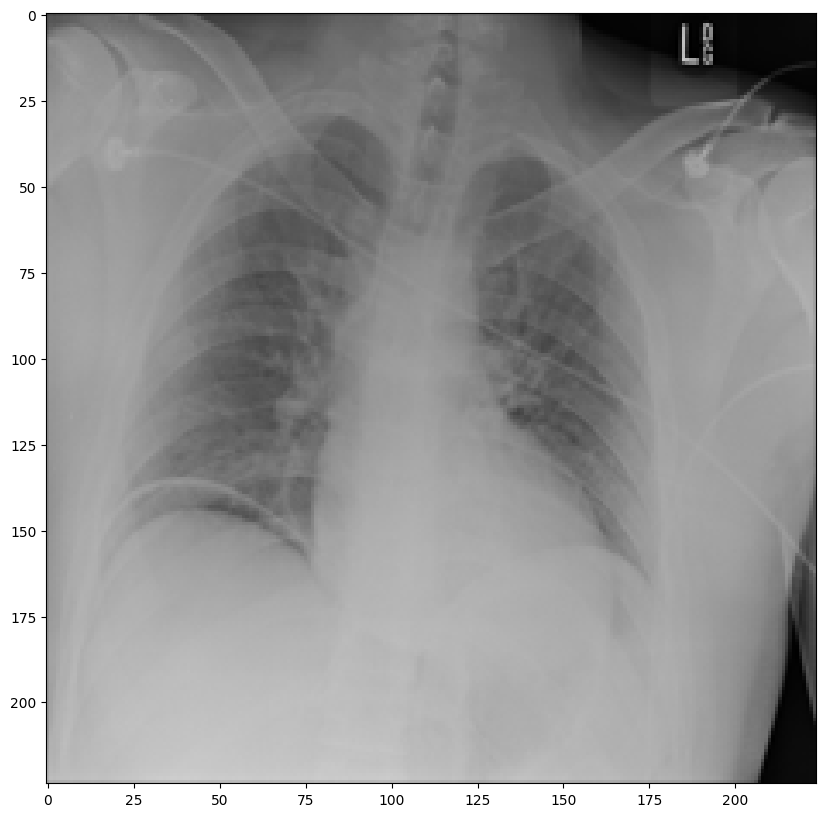

00000357_000.png
tensor(0)


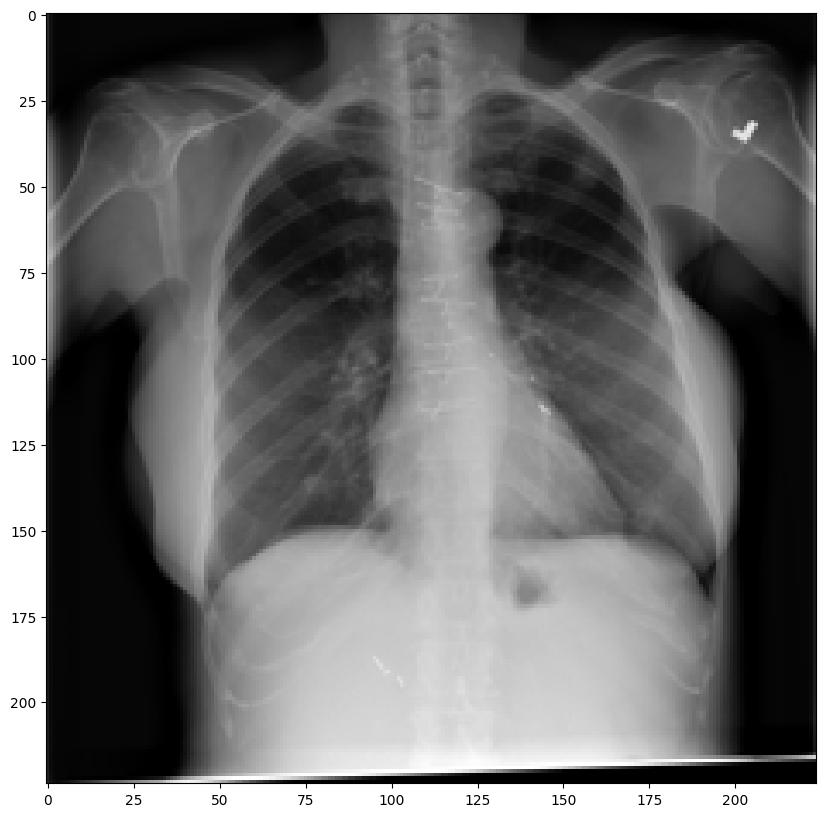

00020384_000.png
tensor(0)


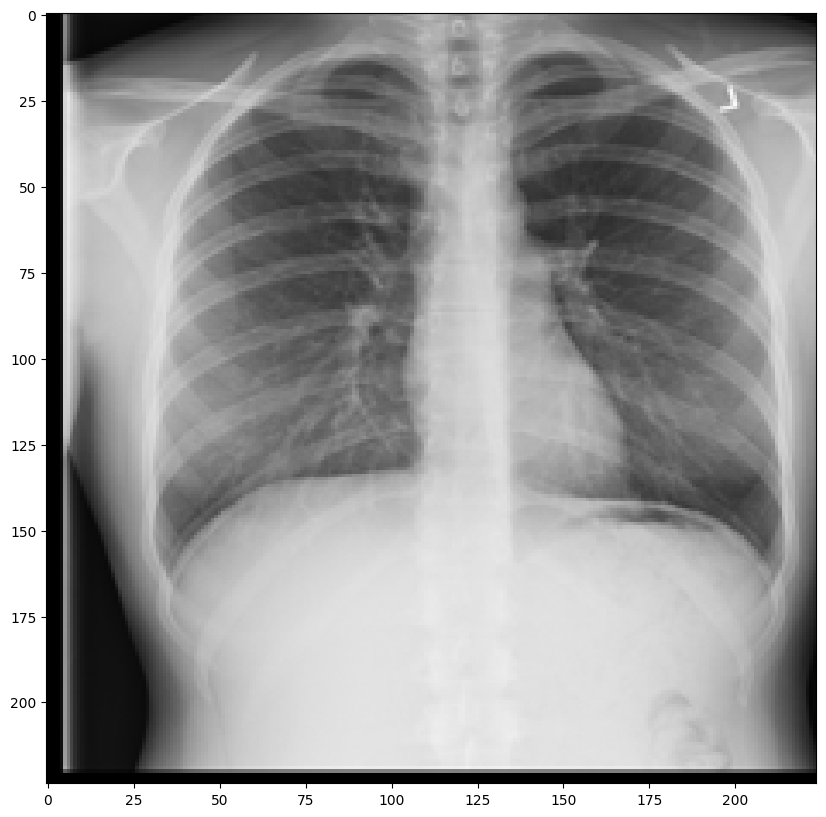

In [20]:
someImages = None
someLabels = None
somePaths = None
i=0
for X,y,path in iter(train_dl):
    someImages=X
    someLabels=y
    somePaths = path
    break

for i in range(0,3):
    print(somePaths[i])
    print(someLabels[i])
    displayImg(someImages[i])

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model=resnet18(num_classes = 2).to(device)
model.load_state_dict(torch.load('best.pkl'))

Using cuda device


<All keys matched successfully>

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
#optimizer.load_state_dict(torch.load('optim_data.pkl'))
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=200,eta_min=0.001,last_epoch=-1)

00009331_000.png
tensor(0, device='cuda:0')
tensor([0], device='cuda:0')


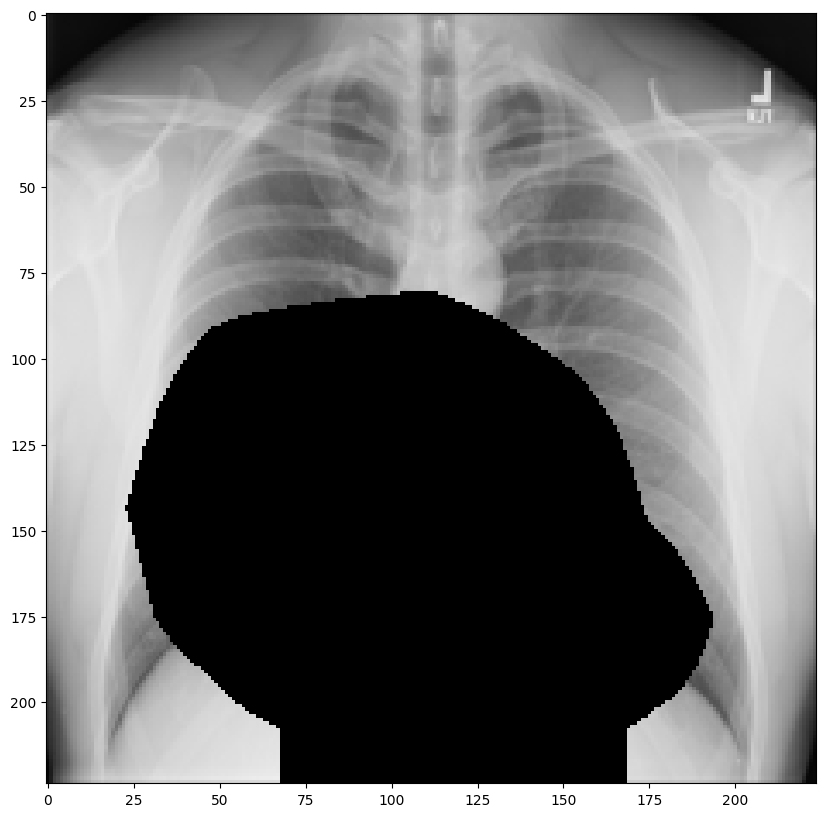

00010912_000.png
tensor(0, device='cuda:0')
tensor([0], device='cuda:0')


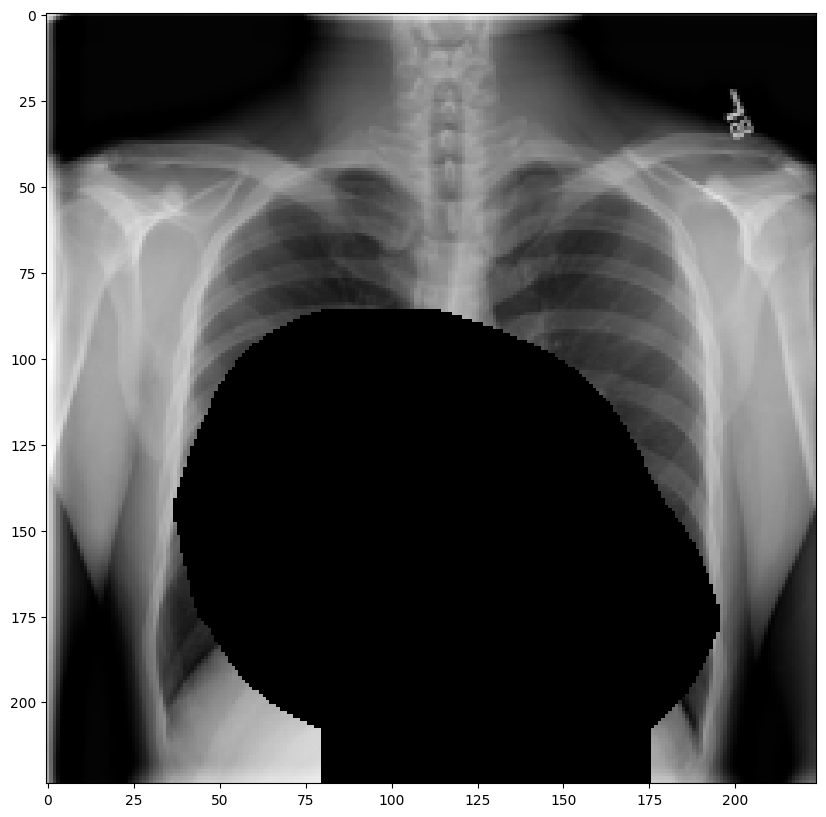

00001104_001.png
tensor(0, device='cuda:0')
tensor([0], device='cuda:0')


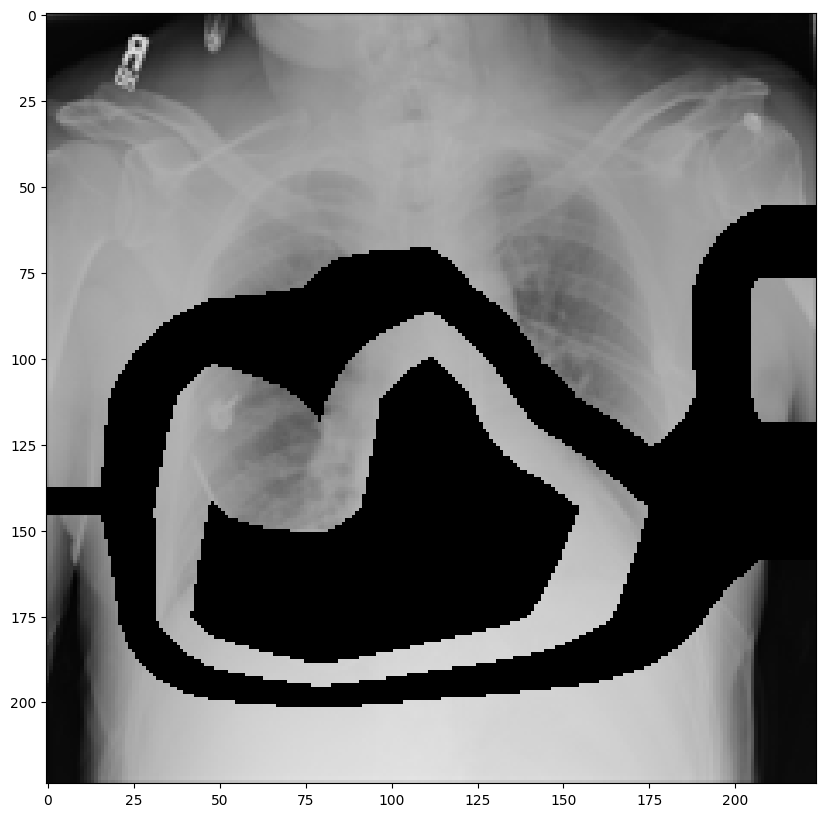

In [23]:
for X,y,path in iter(train_dl):
    X,y = X.to(device),y.to(device)
    normal_X = normal_transform(X).to(device)
    for i in range(3):
        print(path[i])
        print(y[i])
        print(model(normal_X[i:i+1]).argmax(1))
        grayscale_cam = torch.tensor(cv2.imread('./heatmaps/'+path[i], cv2.IMREAD_GRAYSCALE)/255).to(device)
        grayscale_cam = grayscale_cam - 1
        indices8 = (grayscale_cam < -0.75)
        indices6 = (grayscale_cam < -0.55)
        indices4 = (grayscale_cam < -0.35)
        indices2 = (grayscale_cam < -0.15)
        indices0 = (grayscale_cam < 0.05)
        grayscale_cam[indices0] = -1 if random.random()<0.3 else 0
        grayscale_cam[indices2] = -1 if random.random()<0.4 else 0
        grayscale_cam[indices4] = -1 if random.random()<0.6 else 0
        grayscale_cam[indices6] = -1 if random.random()<0.8 else 0
        grayscale_cam[indices8] = -1 if random.random()<1 else 0
        X[i,:] += grayscale_cam
        X[i] = torch.clamp(X[i],0,1)
        displayImg(X[i].cpu())
    break

In [24]:
class TrainImageFolder(datasets.ImageFolder):  
    def __init__(self, root, transform=None, target_transform=None,  
                 loader=datasets.folder.default_loader,  
                 is_valid_file=None,):  
        super(TrainImageFolder, self).__init__(root, transform, target_transform, loader, is_valid_file)  

    def __getitem__(self, index): 
        path, _ = self.samples[index] 
        sample, target = super(TrainImageFolder, self).__getitem__(index) 
        heatmap = self.transform(self.loader('./heatmaps/'+path[-16:]))
        return sample, target, heatmap

train_ds = TrainImageFolder('task_images_downsampled/train',
                                transform = train_transform,)
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers = get_dataloader_workers())

tensor(0)


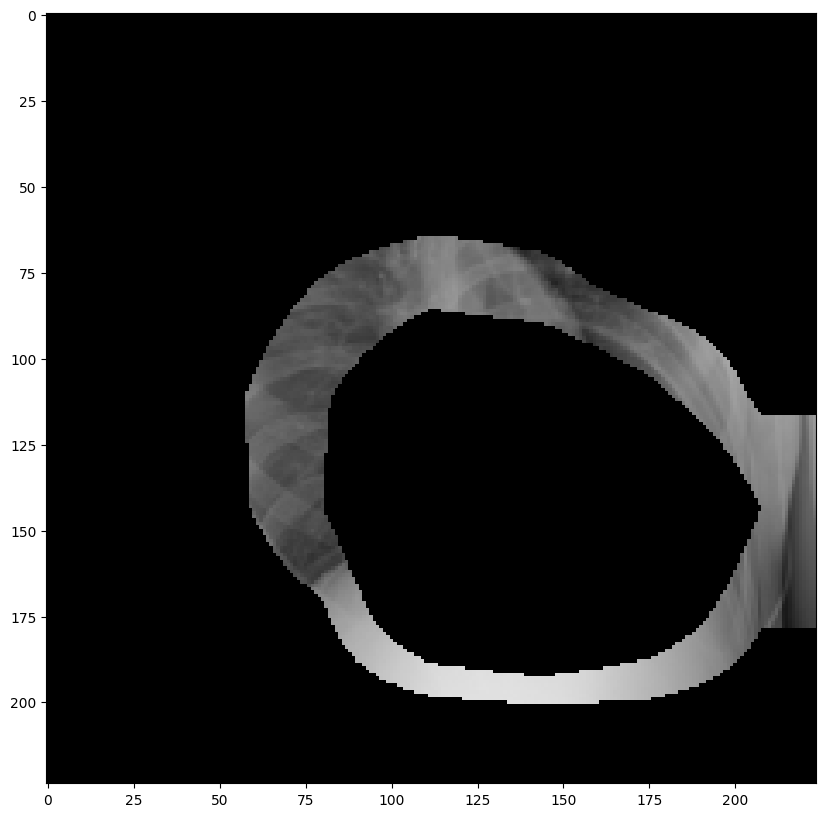

tensor(0)


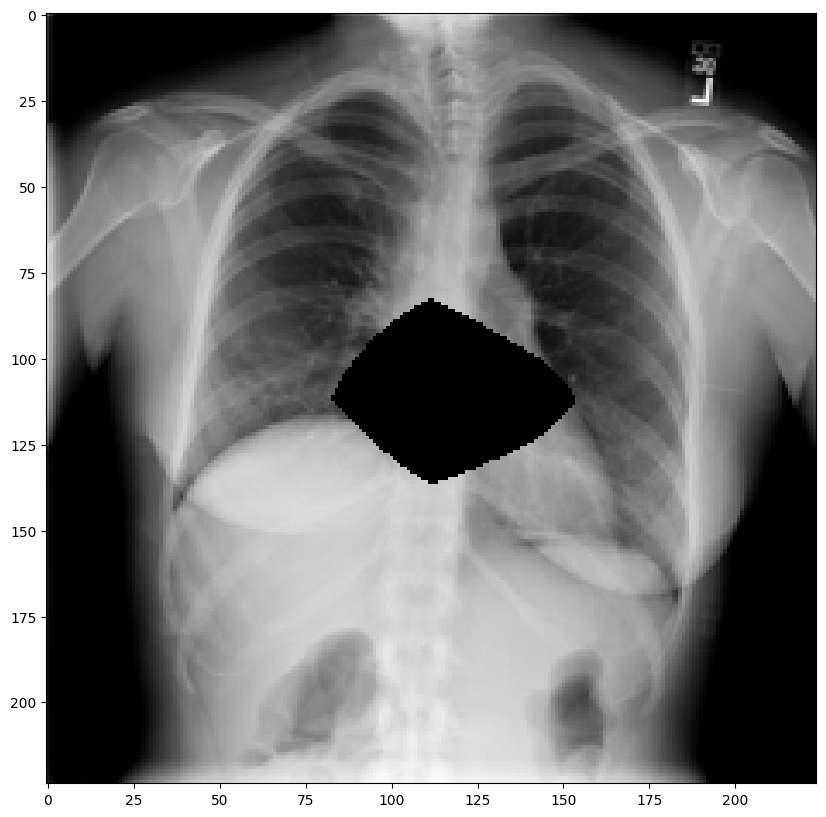

tensor(0)


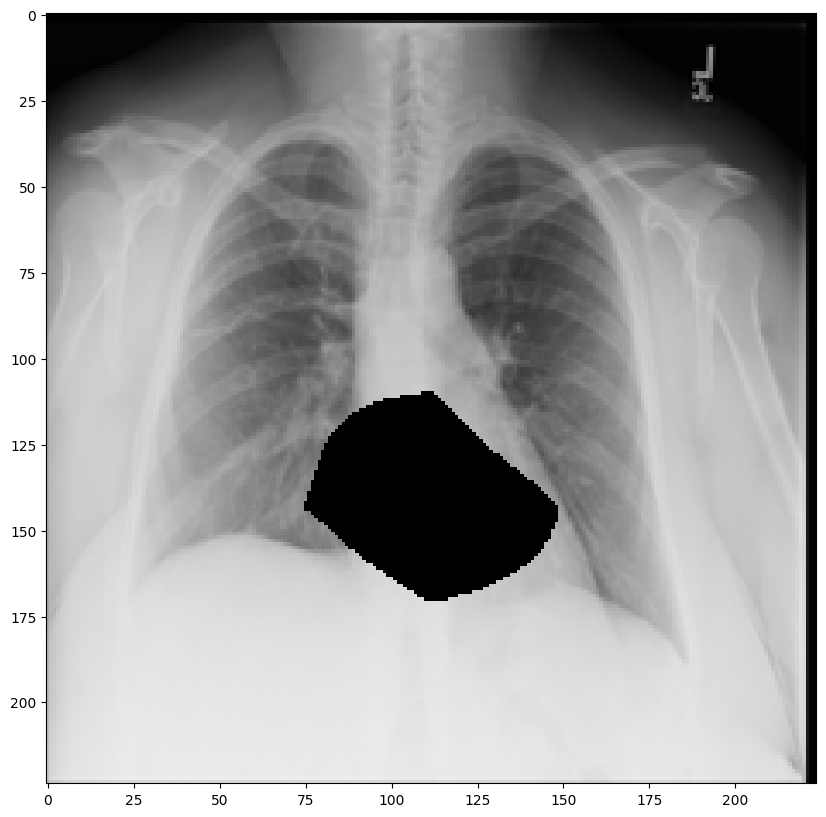

In [25]:
someImages = 0
someLabels = 0
someMasks = 0
i=0
for X,y,M in iter(train_dl):
    someImages=X
    someLabels=y
    someMasks = M
    break

for i in range(0,3):
    print(someLabels[i])
    someMasks[i]-=1
    indices8 = (someMasks[i] < -0.75)
    indices6 = (someMasks[i] < -0.55)
    indices4 = (someMasks[i] < -0.35)
    indices2 = (someMasks[i] < -0.15)
    indices0 = (someMasks[i] < 0.05)
    someMasks[i][indices0] = -1 if random.random()<0.3 else 0
    someMasks[i][indices2] = -1 if random.random()<0.4 else 0
    someMasks[i][indices4] = -1 if random.random()<0.6 else 0
    someMasks[i][indices6] = -1 if random.random()<0.8 else 0
    someMasks[i][indices8] = -1 if random.random()<1.0 else 0
    someImages[i] += someMasks[i]
    someImages[i] = torch.clamp(someImages[i],0,1)
    displayImg(someImages[i])

In [26]:
def train_gaussian(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    train_accuracy =0
    model.train()
    for X,y,grayscale_cam in tqdm(dataloader):
        X,y,grayscale_cam = X.to(device), y.to(device), grayscale_cam.to(device)
        for j in range(len(X)):
            grayscale_cam[j]-=1
            indices8 = (grayscale_cam[j] < -0.75)
            indices6 = (grayscale_cam[j] < -0.55)
            indices4 = (grayscale_cam[j] < -0.35)
            indices2 = (grayscale_cam[j] < -0.15)
            indices0 = (grayscale_cam[j] < 0.05)
            grayscale_cam[j][indices0] = -1 if random.random()<0.3 else 0
            grayscale_cam[j][indices2] = -1 if random.random()<0.4 else 0
            grayscale_cam[j][indices4] = -1 if random.random()<0.6 else 0
            grayscale_cam[j][indices6] = -1 if random.random()<0.8 else 0
            grayscale_cam[j][indices8] = -1 if random.random()<1.0 else 0
            X[j] += grayscale_cam[j]
            X[j] = torch.clamp(X[j],0,1)
        
        X = train_transform_gpu(X)
        # compute prediction
        predict = model(X)
        # compute loss
        loss = loss_fn(predict,y)
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        optimizer.step()
        # record loss
        train_loss += loss.item()
        train_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()
    return train_loss,train_accuracy/size

def train(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    train_accuracy =0
    model.train()
    for X,y,_ in tqdm(dataloader):
        X,y = X.to(device), y.to(device)
        X = train_transform_gpu(X)
        # compute prediction
        predict = model(X)
        # compute loss
        loss = loss_fn(predict,y)
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        optimizer.step()
        # record loss
        train_loss += loss.item()
        train_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()  
    return train_loss,train_accuracy/size

def test(dataloader,model,loss_fn):
    size = len(dataloader.dataset)
    test_loss = 0
    test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for X,y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            X = test_transform_gpu(X)
            predict = model(X)
            loss = loss_fn(predict,y)
            test_loss += loss.item()
            test_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()
            
    return test_loss,test_accuracy/size

In [12]:
epochs = 75
for i in range(epochs):
    print('Epoch,',i)
    train_loss,train_accuracy = train_gaussian(train_dl,model,loss_fn,optimizer)
    test_loss,test_accuracy = test(test_dl,model,loss_fn)
    print("train_loss:",train_loss,"  train_accuracy:",train_accuracy*100)
    print("test_loss:",test_loss,"  test_accuracy:",test_accuracy*100)

Epoch, 0


100%|██████████| 188/188 [00:06<00:00, 29.44it/s]


train_loss: 319.87545654177666   train_accuracy: 85.10976361101203
test_loss: 76.17952843010426   test_accuracy: 86.55833333333334
Epoch, 1


100%|██████████| 188/188 [00:06<00:00, 29.41it/s]


train_loss: 303.5961636006832   train_accuracy: 86.20091442653782
test_loss: 62.97101788967848   test_accuracy: 87.1
Epoch, 2


100%|██████████| 188/188 [00:06<00:00, 30.28it/s]


train_loss: 296.99018339812756   train_accuracy: 86.5089659197769
test_loss: 100.31864720582962   test_accuracy: 76.4
Epoch, 3


100%|██████████| 188/188 [00:06<00:00, 29.65it/s]


train_loss: 294.54402850568295   train_accuracy: 86.72946593599015
test_loss: 58.783618196845055   test_accuracy: 87.03333333333333
Epoch, 4


100%|██████████| 188/188 [00:06<00:00, 30.28it/s]


train_loss: 291.465618789196   train_accuracy: 86.90456889004183
test_loss: 71.01331858336926   test_accuracy: 87.20833333333333
Epoch, 5


100%|██████████| 188/188 [00:06<00:00, 29.69it/s]


train_loss: 288.5415840893984   train_accuracy: 87.17695126301112
test_loss: 59.18985253944993   test_accuracy: 86.91666666666666
Epoch, 6


100%|██████████| 188/188 [00:06<00:00, 30.04it/s]


train_loss: 287.23165333271027   train_accuracy: 87.14614611368722
test_loss: 77.49293860793114   test_accuracy: 80.70833333333334
Epoch, 7


100%|██████████| 188/188 [00:06<00:00, 29.55it/s]


train_loss: 287.19496274739504   train_accuracy: 87.13803949544408
test_loss: 69.48989315330982   test_accuracy: 87.29166666666667
Epoch, 8


100%|██████████| 188/188 [00:06<00:00, 29.73it/s]


train_loss: 285.88575641810894   train_accuracy: 87.19478582314602
test_loss: 67.25753129273653   test_accuracy: 86.34166666666667
Epoch, 9


100%|██████████| 188/188 [00:06<00:00, 29.77it/s]


train_loss: 283.9144739806652   train_accuracy: 87.30665715490126
test_loss: 62.74201460182667   test_accuracy: 87.15833333333333
Epoch, 10


100%|██████████| 188/188 [00:06<00:00, 29.89it/s]


train_loss: 283.2521540224552   train_accuracy: 87.34881156976556
test_loss: 70.38447836786509   test_accuracy: 84.88333333333333
Epoch, 11


100%|██████████| 188/188 [00:06<00:00, 29.63it/s]


train_loss: 282.56998337060213   train_accuracy: 87.38448069003535
test_loss: 76.0247110426426   test_accuracy: 81.55833333333334
Epoch, 12


100%|██████████| 188/188 [00:06<00:00, 29.73it/s]


train_loss: 282.3968270421028   train_accuracy: 87.45744025422356
test_loss: 76.83435325324535   test_accuracy: 84.81666666666666
Epoch, 13


100%|██████████| 188/188 [00:06<00:00, 30.23it/s]


train_loss: 280.5509939342737   train_accuracy: 87.46554687246669
test_loss: 70.31861864030361   test_accuracy: 85.18333333333334
Epoch, 14


100%|██████████| 188/188 [00:06<00:00, 29.96it/s]


train_loss: 280.1786331385374   train_accuracy: 87.53688511300626
test_loss: 79.37277229130268   test_accuracy: 85.40833333333333
Epoch, 15


100%|██████████| 188/188 [00:06<00:00, 30.13it/s]


train_loss: 279.473649173975   train_accuracy: 87.56606893868154
test_loss: 85.78780946135521   test_accuracy: 82.71666666666667
Epoch, 16


100%|██████████| 188/188 [00:06<00:00, 30.01it/s]


train_loss: 279.2759837061167   train_accuracy: 87.59525276435683
test_loss: 71.75378827750683   test_accuracy: 86.925
Epoch, 17


100%|██████████| 188/188 [00:06<00:00, 29.65it/s]


train_loss: 276.8889045715332   train_accuracy: 87.68280424138266
test_loss: 67.57419529557228   test_accuracy: 86.65833333333333
Epoch, 18


100%|██████████| 188/188 [00:06<00:00, 30.29it/s]


train_loss: 277.8176053315401   train_accuracy: 87.58552482246506
test_loss: 74.76700234413147   test_accuracy: 83.33333333333334
Epoch, 19


100%|██████████| 188/188 [00:06<00:00, 30.16it/s]


train_loss: 277.15360145270824   train_accuracy: 87.5936314407082
test_loss: 87.04921320080757   test_accuracy: 81.28333333333333
Epoch, 20


100%|██████████| 188/188 [00:06<00:00, 29.65it/s]


train_loss: 277.940925270319   train_accuracy: 87.60335938259996
test_loss: 78.53268215060234   test_accuracy: 80.24166666666666
Epoch, 21


100%|██████████| 188/188 [00:06<00:00, 29.93it/s]


train_loss: 276.08657866716385   train_accuracy: 87.77197704205713
test_loss: 71.66963776946068   test_accuracy: 85.975
Epoch, 22


100%|██████████| 188/188 [00:06<00:00, 29.79it/s]


train_loss: 274.7859865427017   train_accuracy: 87.78332630759752
test_loss: 75.12049089372158   test_accuracy: 86.53333333333333
Epoch, 23


100%|██████████| 188/188 [00:06<00:00, 30.05it/s]


train_loss: 275.73917557299137   train_accuracy: 87.76062777651676
test_loss: 72.90412150323391   test_accuracy: 85.32499999999999
Epoch, 24


100%|██████████| 188/188 [00:06<00:00, 29.57it/s]


train_loss: 276.50641874969006   train_accuracy: 87.78494763124614
test_loss: 88.58619874715805   test_accuracy: 80.575
Epoch, 25


100%|██████████| 188/188 [00:06<00:00, 29.39it/s]


train_loss: 274.05512560904026   train_accuracy: 87.90168293394728
test_loss: 66.97316938638687   test_accuracy: 85.44166666666668
Epoch, 26


100%|██████████| 188/188 [00:06<00:00, 30.09it/s]


train_loss: 274.6733874976635   train_accuracy: 87.83520866435359
test_loss: 60.23120408505201   test_accuracy: 86.66666666666667
Epoch, 27


100%|██████████| 188/188 [00:06<00:00, 30.15it/s]


train_loss: 274.35535595566034   train_accuracy: 87.85304322448847
test_loss: 74.09614358842373   test_accuracy: 83.90833333333333
Epoch, 28


100%|██████████| 188/188 [00:06<00:00, 29.83it/s]


train_loss: 273.6835521161556   train_accuracy: 87.74441454003048
test_loss: 79.66801485419273   test_accuracy: 83.74166666666667
Epoch, 29


100%|██████████| 188/188 [00:06<00:00, 30.55it/s]


train_loss: 271.9257699549198   train_accuracy: 87.95356529070332
test_loss: 79.71295849978924   test_accuracy: 81.975
Epoch, 30


100%|██████████| 188/188 [00:06<00:00, 29.86it/s]


train_loss: 272.73083443939686   train_accuracy: 87.9146535231363
test_loss: 71.42555786669254   test_accuracy: 84.13333333333334
Epoch, 31


100%|██████████| 188/188 [00:06<00:00, 30.31it/s]


train_loss: 272.08609663695097   train_accuracy: 87.92924543597393
test_loss: 77.52830629050732   test_accuracy: 84.80833333333334
Epoch, 32


100%|██████████| 188/188 [00:06<00:00, 29.56it/s]


train_loss: 270.96328338235617   train_accuracy: 87.94383734881157
test_loss: 66.67617822438478   test_accuracy: 86.29166666666667
Epoch, 33


100%|██████████| 188/188 [00:06<00:00, 29.59it/s]


train_loss: 269.9663731753826   train_accuracy: 88.0362527967833
test_loss: 64.02459277957678   test_accuracy: 85.775
Epoch, 34


100%|██████████| 188/188 [00:06<00:00, 30.03it/s]


train_loss: 270.69704534113407   train_accuracy: 87.98923441097311
test_loss: 102.92918795347214   test_accuracy: 69.31666666666668
Epoch, 35


100%|██████████| 188/188 [00:06<00:00, 30.04it/s]


train_loss: 269.5316673219204   train_accuracy: 88.11894030286325
test_loss: 70.31225641816854   test_accuracy: 85.775
Epoch, 36


100%|██████████| 188/188 [00:06<00:00, 30.04it/s]


train_loss: 269.3845244795084   train_accuracy: 88.03301014948603
test_loss: 104.48667567968369   test_accuracy: 68.63333333333334
Epoch, 37


100%|██████████| 188/188 [00:06<00:00, 30.22it/s]


train_loss: 268.7552371174097   train_accuracy: 88.24540354745615
test_loss: 58.56294248625636   test_accuracy: 86.09166666666667
Epoch, 38


100%|██████████| 188/188 [00:06<00:00, 29.73it/s]


train_loss: 267.98459473252296   train_accuracy: 88.15623074678167
test_loss: 62.92075706273317   test_accuracy: 86.65
Epoch, 39


100%|██████████| 188/188 [00:06<00:00, 29.65it/s]


train_loss: 268.3562913313508   train_accuracy: 88.1335322157009
test_loss: 107.68295729160309   test_accuracy: 72.15833333333333
Epoch, 40


100%|██████████| 188/188 [00:06<00:00, 29.46it/s]


train_loss: 267.4836821779609   train_accuracy: 88.26485943123966
test_loss: 56.85053944773972   test_accuracy: 86.47500000000001
Epoch, 41


100%|██████████| 188/188 [00:06<00:00, 30.20it/s]


train_loss: 266.8960312008858   train_accuracy: 88.26972340218553
test_loss: 73.40201894938946   test_accuracy: 83.76666666666667
Epoch, 42


100%|██████████| 188/188 [00:06<00:00, 29.95it/s]


train_loss: 266.67764730751514   train_accuracy: 88.28431531502319
test_loss: 77.27405483275652   test_accuracy: 80.85833333333333
Epoch, 43


100%|██████████| 188/188 [00:06<00:00, 30.12it/s]


train_loss: 264.80218486487865   train_accuracy: 88.26972340218553
test_loss: 84.51047986745834   test_accuracy: 81.55833333333334
Epoch, 44


100%|██████████| 188/188 [00:06<00:00, 30.42it/s]


train_loss: 265.6344917714596   train_accuracy: 88.36700282110314
test_loss: 89.4865320622921   test_accuracy: 77.91666666666667
Epoch, 45


100%|██████████| 188/188 [00:06<00:00, 30.20it/s]


train_loss: 265.02896535396576   train_accuracy: 88.31187781704985
test_loss: 83.02865687012672   test_accuracy: 81.15833333333333
Epoch, 46


100%|██████████| 188/188 [00:06<00:00, 29.98it/s]


train_loss: 264.6471201479435   train_accuracy: 88.32484840623886
test_loss: 69.70180842280388   test_accuracy: 84.52499999999999
Epoch, 47


100%|██████████| 188/188 [00:07<00:00, 25.53it/s]


train_loss: 263.77892944961786   train_accuracy: 88.34430429002238
test_loss: 63.07436756789684   test_accuracy: 84.675
Epoch, 48


100%|██████████| 188/188 [00:06<00:00, 29.22it/s]


train_loss: 263.51999739557505   train_accuracy: 88.42374914880509
test_loss: 115.19466587901115   test_accuracy: 62.875
Epoch, 49


100%|██████████| 188/188 [00:06<00:00, 30.06it/s]


train_loss: 262.44908940047026   train_accuracy: 88.47563150556114
test_loss: 69.96657280623913   test_accuracy: 83.275
Epoch, 50


100%|██████████| 188/188 [00:06<00:00, 29.96it/s]


train_loss: 261.94360139220953   train_accuracy: 88.42374914880509
test_loss: 74.89614582061768   test_accuracy: 82.05833333333334
Epoch, 51


100%|██████████| 188/188 [00:06<00:00, 30.25it/s]


train_loss: 261.679268181324   train_accuracy: 88.58912416096501
test_loss: 70.96303209662437   test_accuracy: 82.72500000000001
Epoch, 52


100%|██████████| 188/188 [00:06<00:00, 30.16it/s]


train_loss: 263.9665849581361   train_accuracy: 88.40591458867019
test_loss: 80.73170639574528   test_accuracy: 81.91666666666667
Epoch, 53


100%|██████████| 188/188 [00:06<00:00, 29.80it/s]


train_loss: 261.54375198483467   train_accuracy: 88.58912416096501
test_loss: 75.21239691972733   test_accuracy: 81.96666666666667
Epoch, 54


100%|██████████| 188/188 [00:06<00:00, 30.54it/s]


train_loss: 259.9949290603399   train_accuracy: 88.55507636434385
test_loss: 87.52776426076889   test_accuracy: 77.10833333333333
Epoch, 55


100%|██████████| 188/188 [00:06<00:00, 30.30it/s]


train_loss: 259.7149998769164   train_accuracy: 88.48860209475016
test_loss: 117.61375734210014   test_accuracy: 62.475
Epoch, 56


100%|██████████| 188/188 [00:06<00:00, 30.30it/s]


train_loss: 259.79043938964605   train_accuracy: 88.61668666299167
test_loss: 64.97966021299362   test_accuracy: 84.75833333333334
Epoch, 57


100%|██████████| 188/188 [00:06<00:00, 30.06it/s]


train_loss: 257.42847853153944   train_accuracy: 88.64587048866694
test_loss: 94.34109658002853   test_accuracy: 74.78333333333333
Epoch, 58


100%|██████████| 188/188 [00:06<00:00, 30.21it/s]


train_loss: 258.7092260867357   train_accuracy: 88.6069587210999
test_loss: 86.47994434833527   test_accuracy: 77.325
Epoch, 59


100%|██████████| 188/188 [00:06<00:00, 29.77it/s]


train_loss: 257.5210641697049   train_accuracy: 88.80313888258374
test_loss: 69.11922912299633   test_accuracy: 85.05
Epoch, 60


100%|██████████| 188/188 [00:06<00:00, 30.02it/s]


train_loss: 256.353024110198   train_accuracy: 88.76909108596259
test_loss: 71.49100579321384   test_accuracy: 83.075
Epoch, 61


100%|██████████| 188/188 [00:06<00:00, 29.77it/s]


train_loss: 257.550378754735   train_accuracy: 88.66856901974772
test_loss: 66.73234805464745   test_accuracy: 84.52499999999999
Epoch, 62


100%|██████████| 188/188 [00:06<00:00, 30.04it/s]


train_loss: 256.8047363907099   train_accuracy: 88.72369402380103
test_loss: 74.44913122057915   test_accuracy: 81.04166666666667
Epoch, 63


100%|██████████| 188/188 [00:06<00:00, 30.13it/s]


train_loss: 255.47234340757132   train_accuracy: 88.78530432244884
test_loss: 98.3505038022995   test_accuracy: 73.16666666666667
Epoch, 64


100%|██████████| 188/188 [00:06<00:00, 30.14it/s]


train_loss: 253.99683211743832   train_accuracy: 88.89393300690683
test_loss: 78.52221922576427   test_accuracy: 81.10000000000001
Epoch, 65


100%|██████████| 188/188 [00:06<00:00, 27.14it/s]


train_loss: 253.5649890974164   train_accuracy: 88.87609844677195
test_loss: 84.17729046940804   test_accuracy: 78.78333333333333
Epoch, 66


100%|██████████| 188/188 [00:06<00:00, 28.15it/s]


train_loss: 251.86526950448751   train_accuracy: 89.00742566231071
test_loss: 66.71375671774149   test_accuracy: 84.78333333333333
Epoch, 67


100%|██████████| 188/188 [00:06<00:00, 26.96it/s]


train_loss: 252.41411461681128   train_accuracy: 88.99121242582444
test_loss: 81.03652881085873   test_accuracy: 79.76666666666667
Epoch, 68


100%|██████████| 188/188 [00:06<00:00, 27.75it/s]


train_loss: 251.34238838404417   train_accuracy: 89.01391095690522
test_loss: 82.47407247126102   test_accuracy: 81.3
Epoch, 69


100%|██████████| 188/188 [00:06<00:00, 26.94it/s]


train_loss: 252.4636103361845   train_accuracy: 88.85015726839391
test_loss: 67.59890662878752   test_accuracy: 84.64166666666667
Epoch, 70


100%|██████████| 188/188 [00:06<00:00, 30.01it/s]


train_loss: 250.93267076462507   train_accuracy: 89.03174551704011
test_loss: 65.02237373311073   test_accuracy: 85.69166666666666
Epoch, 71


100%|██████████| 188/188 [00:06<00:00, 27.60it/s]


train_loss: 249.68192908912897   train_accuracy: 89.12091831771458
test_loss: 79.69831889867783   test_accuracy: 79.96666666666667
Epoch, 72


100%|██████████| 188/188 [00:07<00:00, 26.20it/s]


train_loss: 250.55443263053894   train_accuracy: 89.03012419339149
test_loss: 96.72563508152962   test_accuracy: 73.06666666666666
Epoch, 73


100%|██████████| 188/188 [00:07<00:00, 25.53it/s]


train_loss: 248.08403193950653   train_accuracy: 89.2490028859561
test_loss: 78.7545517385006   test_accuracy: 80.09166666666667
Epoch, 74


100%|██████████| 188/188 [00:07<00:00, 26.62it/s]

train_loss: 248.05367696285248   train_accuracy: 89.15496611433575
test_loss: 72.84707332402468   test_accuracy: 85.04166666666667


In [13]:
torch.save(model.state_dict(), 'best_augmented.pkl')

In [27]:
epochs = 25
model.load_state_dict(torch.load('best_augmented.pkl'))
for i in range(epochs):
    print('Epoch,',i)
    train_loss,train_accuracy = train(train_dl,model,loss_fn,optimizer)
    test_loss,test_accuracy = test(test_dl,model,loss_fn)
    print("train_loss:",train_loss,"  train_accuracy:",train_accuracy*100)
    print("test_loss:",test_loss,"  test_accuracy:",test_accuracy*100)
    scheduler.step()

Epoch, 0


100%|██████████| 188/188 [00:06<00:00, 28.13it/s]


train_loss: 255.52596344053745   train_accuracy: 88.58912416096501
test_loss: 52.689176578074694   test_accuracy: 87.99166666666667
Epoch, 1


100%|██████████| 188/188 [00:06<00:00, 27.33it/s]


train_loss: 241.08926653862   train_accuracy: 89.30088524271214
test_loss: 55.33452747017145   test_accuracy: 86.88333333333334
Epoch, 2


100%|██████████| 188/188 [00:06<00:00, 27.17it/s]


train_loss: 236.04225304722786   train_accuracy: 89.6916242420312
test_loss: 55.038021453656256   test_accuracy: 87.06666666666666
Epoch, 3


100%|██████████| 188/188 [00:06<00:00, 27.17it/s]


train_loss: 231.87767941504717   train_accuracy: 89.75971983527351
test_loss: 53.93848549714312   test_accuracy: 88.3
Epoch, 4


100%|██████████| 188/188 [00:06<00:00, 27.42it/s]


train_loss: 226.70266274362803   train_accuracy: 90.17315736567333
test_loss: 54.58606862323359   test_accuracy: 87.70833333333333
Epoch, 5


100%|██████████| 188/188 [00:07<00:00, 26.77it/s]


train_loss: 219.68950571864843   train_accuracy: 90.42446253121048
test_loss: 55.43785424157977   test_accuracy: 87.71666666666667
Epoch, 6


100%|██████████| 188/188 [00:07<00:00, 26.22it/s]


train_loss: 216.3102126941085   train_accuracy: 90.55416842310062
test_loss: 58.53434344753623   test_accuracy: 86.85833333333333
Epoch, 7


100%|██████████| 188/188 [00:07<00:00, 25.71it/s]


train_loss: 212.37033397704363   train_accuracy: 90.73899931904407
test_loss: 56.708529910072684   test_accuracy: 87.7
Epoch, 8


100%|██████████| 188/188 [00:07<00:00, 25.92it/s]


train_loss: 209.18317505717278   train_accuracy: 90.88329712377184
test_loss: 57.38684076210484   test_accuracy: 88.04166666666666
Epoch, 9


100%|██████████| 188/188 [00:06<00:00, 28.62it/s]


train_loss: 204.4737337604165   train_accuracy: 91.08758390349881
test_loss: 59.868944321293384   test_accuracy: 87.725
Epoch, 10


100%|██████████| 188/188 [00:06<00:00, 27.75it/s]


train_loss: 199.48293583840132   train_accuracy: 91.45724569538571
test_loss: 59.23576728720218   test_accuracy: 86.79166666666667
Epoch, 11


100%|██████████| 188/188 [00:06<00:00, 27.83it/s]


train_loss: 194.9596091993153   train_accuracy: 91.54966114335744
test_loss: 60.42551529034972   test_accuracy: 87.14166666666667
Epoch, 12


100%|██████████| 188/188 [00:06<00:00, 29.61it/s]


train_loss: 191.02427829802036   train_accuracy: 91.80420895619183
test_loss: 65.85824575088918   test_accuracy: 87.00833333333333
Epoch, 13


100%|██████████| 188/188 [00:06<00:00, 28.81it/s]


train_loss: 186.8153141885996   train_accuracy: 91.93067220078473
test_loss: 61.061759600415826   test_accuracy: 87.50833333333333
Epoch, 14


100%|██████████| 188/188 [00:06<00:00, 29.51it/s]


train_loss: 181.93027757108212   train_accuracy: 92.12523103861993
test_loss: 62.771727204322815   test_accuracy: 86.775
Epoch, 15


100%|██████████| 188/188 [00:06<00:00, 30.52it/s]


train_loss: 176.12446876987815   train_accuracy: 92.35708032037356
test_loss: 67.94703579496127   test_accuracy: 87.15
Epoch, 16


100%|██████████| 188/188 [00:06<00:00, 28.67it/s]


train_loss: 172.6472437158227   train_accuracy: 92.61162813320794
test_loss: 64.62261097272858   test_accuracy: 87.09166666666667
Epoch, 17


100%|██████████| 188/188 [00:06<00:00, 29.89it/s]


train_loss: 165.6442749761045   train_accuracy: 92.98128992509484
test_loss: 67.7595309377939   test_accuracy: 87.71666666666667
Epoch, 18


100%|██████████| 188/188 [00:06<00:00, 29.79it/s]


train_loss: 161.6019790135324   train_accuracy: 93.18233405752456
test_loss: 69.05490800086409   test_accuracy: 86.9
Epoch, 19


100%|██████████| 188/188 [00:06<00:00, 30.20it/s]


train_loss: 157.34020744264126   train_accuracy: 93.3055546548202
test_loss: 78.23133286088705   test_accuracy: 85.03333333333333
Epoch, 20


100%|██████████| 188/188 [00:06<00:00, 29.70it/s]


train_loss: 151.957216296345   train_accuracy: 93.51632672914167
test_loss: 78.57319952081889   test_accuracy: 85.01666666666667
Epoch, 21


100%|██████████| 188/188 [00:06<00:00, 29.98it/s]


train_loss: 146.52036756649613   train_accuracy: 93.81302895684036
test_loss: 88.1511269416078   test_accuracy: 87.71666666666667
Epoch, 22


100%|██████████| 188/188 [00:06<00:00, 29.85it/s]


train_loss: 141.8878193963319   train_accuracy: 94.03839294399948
test_loss: 77.62537309061736   test_accuracy: 87.225
Epoch, 23


100%|██████████| 188/188 [00:06<00:00, 29.82it/s]


train_loss: 136.74385130777955   train_accuracy: 94.18755471967314
test_loss: 76.68453505076468   test_accuracy: 87.3
Epoch, 24


100%|██████████| 188/188 [00:06<00:00, 30.18it/s]

train_loss: 131.94454227760434   train_accuracy: 94.37724958656247
test_loss: 73.04086728114635   test_accuracy: 85.65


In [28]:
torch.save(model.state_dict(), 'best_no_augmented.pkl')